# Setting Up Environment
We will be using Tensorflow 1.15.0

In [ ]:
import tensorflow as tf
print( tf.__version__)

1.15.0


In [ ]:
import os

from keras.utils import HDF5Matrix
from keras.utils.data_utils import get_file
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.xception import Xception
import tensorflow_datasets

import numpy as np
import collections
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_fscore_support, accuracy_score
import random
import time

import seaborn as sns
import pandas as pd
import gc


Using TensorFlow backend.


In [ ]:
# mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Load Data 

*Run Uploading Data section in `BaselineCNN_andDataSetup.ipynb` before this code so correct data is saved within your Google Drive*


In [ ]:
# import the pictures
DATA_DIR = "/content/drive/My Drive/pcamv1_no_gz"

#we don't need training data, we use tensorflow's PCam pre-saved
#x_train = HDF5Matrix(os.path.join(DATA_DIR, 'camelyonpatch_level_2_split_train_x.h5'), 'x')
#y_train = HDF5Matrix(os.path.join(DATA_DIR, 'camelyonpatch_level_2_split_train_y.h5'), 'y')

x_test  = HDF5Matrix(os.path.join(DATA_DIR, 'camelyonpatch_level_2_split_test_x.h5'), 'x')
y_test  = HDF5Matrix(os.path.join(DATA_DIR, 'camelyonpatch_level_2_split_test_y.h5'), 'y')

In [1]:
#load in dataset object of PCam data
pcam, pcam_info = tensorflow_datasets.load("patch_camelyon", with_info=True)

# Transfer Learning 

Two transfer models are trained: ResNet50 and InceptionResNetV2.

Same training data and data autmentation is used.

In [ ]:
# create tensorflow and numpy random seeds
np.random.seed(122)
tf.set_random_seed(6547)

# create shortcut 
tfkl = tf.keras.layers

### ResNet50

In [ ]:
# ResNet50
res_base = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

x = res_base.output
x = tfkl.Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = tfkl.Dropout(rate=0.2)(x)
x = Dense(1024, activation='relu')(x)
x = tfkl.Dropout(rate=0.2)(x)
x = Dense(64, activation='relu')(x)
x = tfkl.Dropout(rate=0.2)(x)
output = Dense(1, activation='sigmoid')(x)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional ResNet50 layers
for layer in res_base.layers:
        if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
          # Reset the batch norm moving averages and allow them to update to the new dataset
            layer.trainable = True
            tf.keras.backend.eval(tf.keras.backend.update(layer.moving_mean, tf.keras.backend.zeros_like(layer.moving_mean)))
            tf.keras.backend.eval(tf.keras.backend.update(layer.moving_variance, tf.keras.backend.zeros_like(layer.moving_variance)))
        else:
            layer.trainable = False

res_model = Model(res_base.input, output)

# Compile model
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
res_model.compile(adam_opt,
                loss='binary_crossentropy',
              metrics=['accuracy'])
              
res_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 48, 48, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# train the model with early stopping
early_stopping = callbacks.EarlyStopping(
    monitor='val_acc',
    min_delta=0,
    patience=2,
    verbose=1,
    mode='auto')

In [ ]:
# need to transform and augment the data before feeding into model
def clean_example(example):
    image, label = example['image'], example['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)

    # some basic data augmentation
    image = tf.image.random_flip_left_right(image, seed=random.seed(time.time()) )
    image = tf.image.random_flip_up_down(image, seed=random.seed(time.time()) )

    return image, label

In [ ]:
#set batch size
train_batch = 256
valid_batch = 128

#set up pipelne for tf.data.datasets for the train and validation data (test data we'll look at later)
train_pipeline = pcam['train'].map(clean_example,
                                   num_parallel_calls=8).repeat().batch(train_batch).prefetch(2)
valid_pipeline = pcam['validation'].map(clean_example,
                                        num_parallel_calls=8).repeat().batch(valid_batch).prefetch(2)

In [ ]:
res_model_history = res_model.fit(train_pipeline,
                 validation_data=valid_pipeline,
                 callbacks=[early_stopping],
                 epochs=5, 
                 steps_per_epoch = 262144 // train_batch,
                 validation_steps=256)

Train on 1024 steps, validate on 256 steps
Epoch 1/5
1024/1024 [==============================] - 285s 278ms/step - loss: 0.2698 - acc: 0.8917 - val_loss: 0.3889 - val_acc: 0.8405
Epoch 2/5
1024/1024 [==============================] - 278s 271ms/step - loss: 0.1720 - acc: 0.9371 - val_loss: 0.4239 - val_acc: 0.8313
Epoch 3/5
1024/1024 [==============================] - 278s 271ms/step - loss: 0.1380 - acc: 0.9510 - val_loss: 0.4335 - val_acc: 0.8468
Epoch 4/5
1024/1024 [==============================] - 278s 271ms/step - loss: 0.1169 - acc: 0.9599 - val_loss: 0.5332 - val_acc: 0.8294
Epoch 5/5
1024/1024 [==============================] - 278s 271ms/step - loss: 0.1032 - acc: 0.9649 - val_loss: 0.4775 - val_acc: 0.8417
Epoch 00005: early stopping


In [ ]:
# save model
res_model.save('/content/drive/My Drive/models/res_model.h5')

# load model
# res_model = tf.keras.models.load_model('/content/drive/My Drive/models/res_model.h5')

#### Train and Validation Performance

First, let's see how the model trained.

In [ ]:
#create function for loss plotting
def plot_loss(results_hist):
  plt.plot(results_hist.history['loss'])
  plt.plot(results_hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.show()

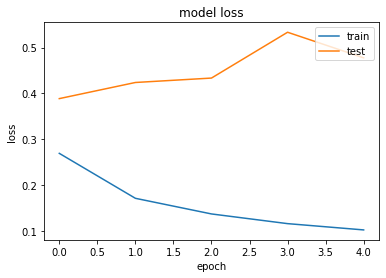

In [ ]:
# Loss plot -- appears to be overfitting slightly
# model accuracy doesn't change much after the first epoch
plot_loss(res_model_history)

#### Test Performance

Next, let's see how well the model performs of the test data.

In [ ]:
# predit with model on validation set
sample_data_generator =  ImageDataGenerator(
              preprocessing_function=lambda x: x/255.)

test_predictions = res_model.predict_generator(sample_data_generator.flow(x_test, batch_size=64, shuffle=False))

In [ ]:
y_pred = test_predictions.flatten() > 0.5

# conf. matrix
print(confusion_matrix(y_test[:].flatten(), y_pred) )

#prec. recall f1
metrics_array = precision_recall_fscore_support(y_test[:].flatten(), y_pred)

print(f"prec. of 0: {metrics_array[0][0]}")
print(f"prec. of 1: {metrics_array[0][1]}")

print(f"recall of 0: {metrics_array[1][0]}")
print(f"recall of 1: {metrics_array[1][1]}")

acc = accuracy_score(y_test[:].flatten(), y_pred)
print(f"accuracy: {acc}")


[[15857   534]
 [ 6710  9667]]
prec. of 0: 0.7026631807506536
prec. of 1: 0.9476521909616704
recall of 0: 0.9674211457507168
recall of 1: 0.5902790498870367
accuracy: 0.7789306640625


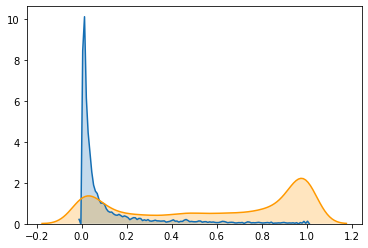

In [ ]:
#create dataframe
df_test = pd.DataFrame({'actual':y_test[:].flatten(), 'probabilities':test_predictions.flatten()})

#Class probability distributions
p1=sns.kdeplot(df_test.probabilities[df_test.actual == 0], shade=True, color="#146EB4", legend = False)
p1=sns.kdeplot(df_test.probabilities[df_test.actual == 1], shade=True, color="#FF9900", legend = False)

Text(0, 0.5, 'True Positive Rate')

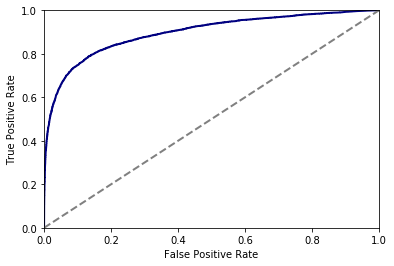

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(df_test.actual, df_test.probabilities)

plt.plot(fpr, tpr, color='navy', lw=2)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### InceptionResNetV2

In [ ]:
# InceptionResNetV2 model
incep_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

x = incep_base.output
x = tfkl.Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = tfkl.Dropout(rate=0.2)(x)
x = Dense(1024, activation='relu')(x)
x = tfkl.Dropout(rate=0.2)(x)
x = Dense(64, activation='relu')(x)
x = tfkl.Dropout(rate=0.2)(x)
output = Dense(1, activation='sigmoid')(x)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in incep_base.layers:
        if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
          # Reset the batch norm moving averages and allow them to update to the new dataset
            layer.trainable = True
            tf.keras.backend.eval(tf.keras.backend.update(layer.moving_mean, tf.keras.backend.zeros_like(layer.moving_mean)))
            tf.keras.backend.eval(tf.keras.backend.update(layer.moving_variance, tf.keras.backend.zeros_like(layer.moving_variance)))
        else:
            layer.trainable = False

incep_model = Model(incep_base.input, output)

# Compile model
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
incep_model.compile(adam_opt,
                loss='binary_crossentropy',
              metrics=['accuracy'])

incep_model.summary()

219062272/219055592 [==============================] - 3s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 47, 47, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 47, 47, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 47, 47, 32)   0           batch_normalization[0][0]        
_________________________

In [ ]:
incept_model_history = incep_model.fit(train_pipeline, # same pipelines as before
                 validation_data=valid_pipeline,
                 callbacks=[early_stopping], # same early stopping params as before
                 epochs=5, 
                 steps_per_epoch = 262144 // train_batch,
                 validation_steps=256)

Train on 1024 steps, validate on 256 steps
Epoch 1/5
1024/1024 [==============================] - 394s 385ms/step - loss: 0.4705 - acc: 0.7741 - val_loss: 0.4420 - val_acc: 0.7898
Epoch 2/5
1024/1024 [==============================] - 350s 342ms/step - loss: 0.3803 - acc: 0.8328 - val_loss: 0.4225 - val_acc: 0.7992
Epoch 3/5
1024/1024 [==============================] - 352s 344ms/step - loss: 0.3343 - acc: 0.8573 - val_loss: 0.4219 - val_acc: 0.8073
Epoch 4/5
1024/1024 [==============================] - 352s 344ms/step - loss: 0.3016 - acc: 0.8732 - val_loss: 0.4350 - val_acc: 0.8002
Epoch 5/5
1024/1024 [==============================] - 351s 342ms/step - loss: 0.2750 - acc: 0.8867 - val_loss: 0.4582 - val_acc: 0.8011
Epoch 00005: early stopping


In [ ]:
# save model
incep_model.save('/content/drive/My Drive/models/incept_model.h5')

# load model
# res_model = tf.keras.models.load_model('/content/drive/My Drive/models/res_model.h5')

#### Train and Validation Performance

First, let's see how the model trained.

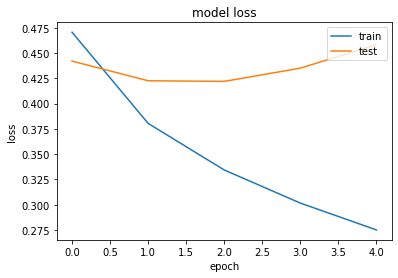

In [ ]:
plot_loss(incept_model_history) # accuracy does not improve much after first epoch -- validation loss doesn't change much either

#### Test Performance

Next, let's see how well the model performs of the test data.

In [ ]:
# predit with model on validation set
test_predictions = incep_model.predict_generator(sample_data_generator.flow(x_test, batch_size=64, shuffle=False))

In [ ]:
y_pred = test_predictions.flatten() > 0.5

# conf. matrix
print(confusion_matrix(y_test[:].flatten(), y_pred) )

#prec. recall f1
metrics_array = precision_recall_fscore_support(y_test[:].flatten(), y_pred)

print(f"prec. of 0: {metrics_array[0][0]}")
print(f"prec. of 1: {metrics_array[0][1]}")

print(f"recall of 0: {metrics_array[1][0]}")
print(f"recall of 1: {metrics_array[1][1]}")

acc = accuracy_score(y_test[:].flatten(), y_pred)
print(f"accuracy: {acc}")


[[14924  1467]
 [ 5301 11076]]
prec. of 0: 0.7378986402966625
prec. of 1: 0.883042334369768
recall of 0: 0.9104996644500031
recall of 1: 0.6763143432863161
accuracy: 0.79345703125


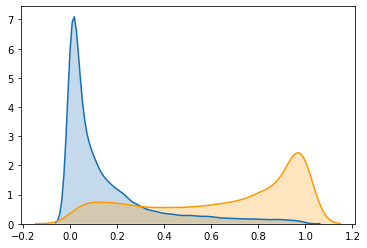

In [ ]:
#create dataframe
df_test = pd.DataFrame({'actual':y_test[:].flatten(), 'probabilities':test_predictions.flatten()})

#Class probability distributions
p1=sns.kdeplot(df_test.probabilities[df_test.actual == 0], shade=True, color="#146EB4", legend = False)
p1=sns.kdeplot(df_test.probabilities[df_test.actual == 1], shade=True, color="#FF9900", legend = False)

Text(0, 0.5, 'True Positive Rate')

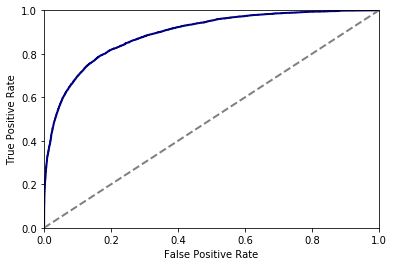

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(df_test.actual, df_test.probabilities)

plt.plot(fpr, tpr, color='navy', lw=2)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### Xception

In [ ]:
# Xception Model
xception_base = Xception(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

x = xception_base.output
x = tfkl.Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = tfkl.Dropout(rate=0.2)(x)
x = Dense(1024, activation='relu')(x)
x = tfkl.Dropout(rate=0.2)(x)
x = Dense(64, activation='relu')(x)
x = tfkl.Dropout(rate=0.2)(x)
output = Dense(1, activation='sigmoid')(x)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in xception_base.layers:
        if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
          # Reset the batch norm moving averages and allow them to update to the new dataset
            layer.trainable = True
            tf.keras.backend.eval(tf.keras.backend.update(layer.moving_mean, tf.keras.backend.zeros_like(layer.moving_mean)))
            tf.keras.backend.eval(tf.keras.backend.update(layer.moving_variance, tf.keras.backend.zeros_like(layer.moving_variance)))
        else:
            layer.trainable = False

xception_model = Model(xception_base.input, output)

# Compile model
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
xception_model.compile(adam_opt,
                loss='binary_crossentropy',
              metrics=['accuracy'])

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
xception_model_history = xception_model.fit(train_pipeline, # same pipelines as before
                 validation_data=valid_pipeline,
                 callbacks=[early_stopping], # same early stopping params as before
                 epochs=5, 
                 steps_per_epoch = 262144 // train_batch,
                 validation_steps=256)

Train on 1024 steps, validate on 256 steps
Epoch 1/5
1024/1024 [==============================] - 344s 336ms/step - loss: 0.3193 - acc: 0.8668 - val_loss: 0.3859 - val_acc: 0.8376
Epoch 2/5
1024/1024 [==============================] - 330s 323ms/step - loss: 0.2041 - acc: 0.9216 - val_loss: 0.4005 - val_acc: 0.8432
Epoch 3/5
1024/1024 [==============================] - 331s 323ms/step - loss: 0.1686 - acc: 0.9373 - val_loss: 0.4155 - val_acc: 0.8414
Epoch 4/5
1024/1024 [==============================] - 330s 322ms/step - loss: 0.1463 - acc: 0.9463 - val_loss: 0.4649 - val_acc: 0.8434
Epoch 5/5
1024/1024 [==============================] - 329s 321ms/step - loss: 0.1297 - acc: 0.9533 - val_loss: 0.4359 - val_acc: 0.8533


In [ ]:
# save model
xception_model.save('/content/drive/My Drive/models/xception_model.h5')

# load model
# res_model = tf.keras.models.load_model('/content/drive/My Drive/models/res_model.h5')

#### Train and Validation Performance

First, let's see how the model trained.

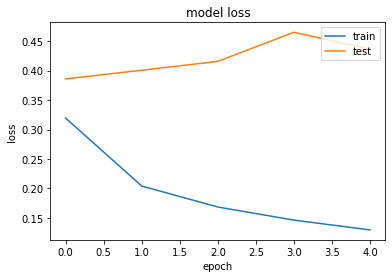

In [ ]:
plot_loss(xception_model_history)

#### Test Performance

Next, let's see how well the model performs of the test data.

In [ ]:
# predit with model on validation set
test_predictions = xception_model.predict_generator(sample_data_generator.flow(x_test, batch_size=64, shuffle=False))

In [ ]:
y_pred = test_predictions.flatten() > 0.5

# conf. matrix
print(confusion_matrix(y_test[:].flatten(), y_pred) )

#prec. recall f1
metrics_array = precision_recall_fscore_support(y_test[:].flatten(), y_pred)

print(f"prec. of 0: {metrics_array[0][0]}")
print(f"prec. of 1: {metrics_array[0][1]}")

print(f"recall of 0: {metrics_array[1][0]}")
print(f"recall of 1: {metrics_array[1][1]}")

acc = accuracy_score(y_test[:].flatten(), y_pred)
print(f"accuracy: {acc}")


[[15694   697]
 [ 5548 10829]]
prec. of 0: 0.738819320214669
prec. of 1: 0.93952802359882
recall of 0: 0.9574766640229394
recall of 1: 0.6612322159125603
accuracy: 0.809417724609375


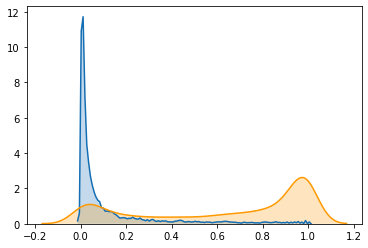

In [ ]:
#create dataframe
df_test = pd.DataFrame({'actual':y_test[:].flatten(), 'probabilities':test_predictions.flatten()})

#Class probability distributions
p1=sns.kdeplot(df_test.probabilities[df_test.actual == 0], shade=True, color="#146EB4", legend = False)
p1=sns.kdeplot(df_test.probabilities[df_test.actual == 1], shade=True, color="#FF9900", legend = False)

Text(0, 0.5, 'True Positive Rate')

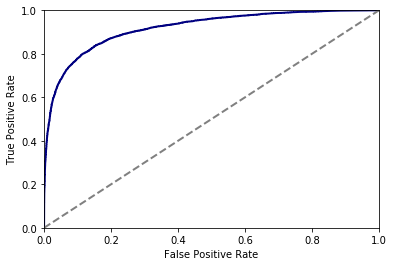

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(df_test.actual, df_test.probabilities)

plt.plot(fpr, tpr, color='navy', lw=2)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## All Models Compared Together

In [ ]:
# import baseline
cnn_baseline = tf.keras.models.load_model('/content/drive/My Drive/models/baseline_model.h5')

In [ ]:
#generate predictions
predictions_res = res_model.predict_generator(sample_data_generator.flow(x_test, batch_size=64, shuffle=False))
predictions_xception = xception_model.predict_generator(sample_data_generator.flow(x_test, batch_size=64, shuffle=False))
predictions_incep = incep_model.predict_generator(sample_data_generator.flow(x_test, batch_size=64, shuffle=False))
predictions_baseline = cnn_baseline.predict_generator(sample_data_generator.flow(x_test, batch_size=64, shuffle=False))

In [ ]:
#create dataframe of all predictions
df_test_all = pd.DataFrame({'actual':y_test[:].flatten(), 
                            'prob_baseline': predictions_baseline.flatten(),
                            'prob_res':predictions_res.flatten(),
                            'prob_xception':predictions_xception.flatten(),
                            'prob_incep':predictions_incep.flatten()})

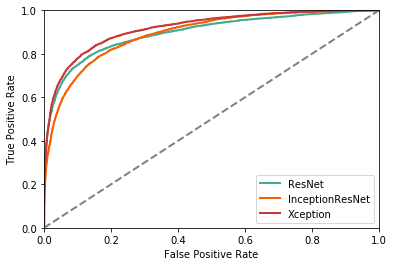

In [ ]:
# put all ROC curves for transfer learning the same plot
fpr_res, tpr_res, _ = roc_curve(df_test_all.actual, df_test_all.prob_res)
fpr_xcep, tpr_xcep, _ = roc_curve(df_test_all.actual, df_test_all.prob_xception)
fpr_incep, tpr_incep, _ = roc_curve(df_test_all.actual, df_test_all.prob_incep)
fpr_base, tpr_base, _ = roc_curve(df_test_all.actual, df_test_all.prob_baseline)


plt.plot(fpr_res, tpr_res, color='#43ab92', lw=2) #ResNet50
plt.plot(fpr_incep, tpr_incep, color='#f75f00', lw=2) #InceptionResNetV2
plt.plot(fpr_xcep, tpr_xcep, color='#c93838', lw=2) #Xception

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(labels = ["ResNet", "InceptionResNet", "Xception"])

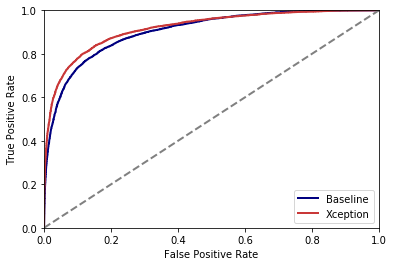

In [ ]:
#plot ROC curves for Xception vs baseline
fpr_res, tpr_res, _ = roc_curve(df_test_all.actual, df_test_all.prob_res)
fpr_xcep, tpr_xcep, _ = roc_curve(df_test_all.actual, df_test_all.prob_xception)
fpr_incep, tpr_incep, _ = roc_curve(df_test_all.actual, df_test_all.prob_incep)
fpr_base, tpr_base, _ = roc_curve(df_test_all.actual, df_test_all.prob_baseline)


plt.plot(fpr_base, tpr_base, color='navy', lw=2) #baseline
plt.plot(fpr_xcep, tpr_xcep, color='#c93838', lw=2) #Xception

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(labels = ["Baseline", "Xception"])